In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
import cv2
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
dataset_path="/kaggle/input/gtsrb-german-traffic-sign"

In [4]:
!ls $dataset_path

meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv


In [5]:
training_data=pd.read_csv(os.path.join(dataset_path,"Train.csv"))
test_data=pd.read_csv(os.path.join(dataset_path,"Test.csv"))

In [6]:
print(training_data.shape)
print(test_data.shape)

(39209, 8)
(12630, 8)


In [7]:
training_data.head(3)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png

# Data Exploration

In [8]:
print("Number of unique classes :",training_data.ClassId.nunique())

Number of unique classes : 43


Text(0.5, 1.0, 'Number of images per class')

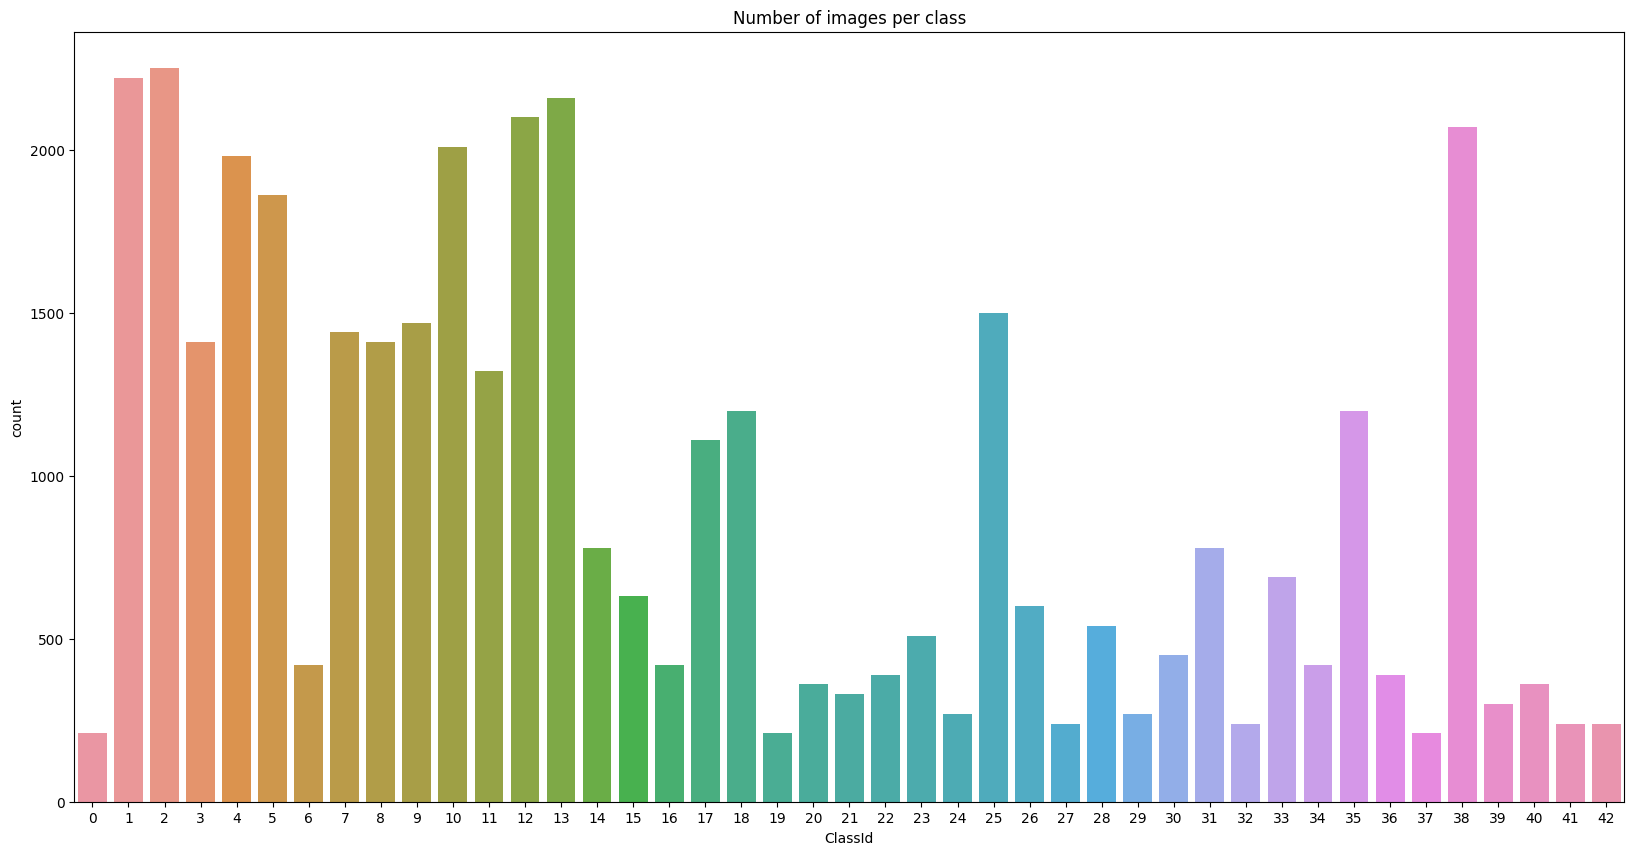

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(x=training_data["ClassId"])
plt.title("Number of images per class")

In [10]:
area=training_data["Width"]*training_data["Height"]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

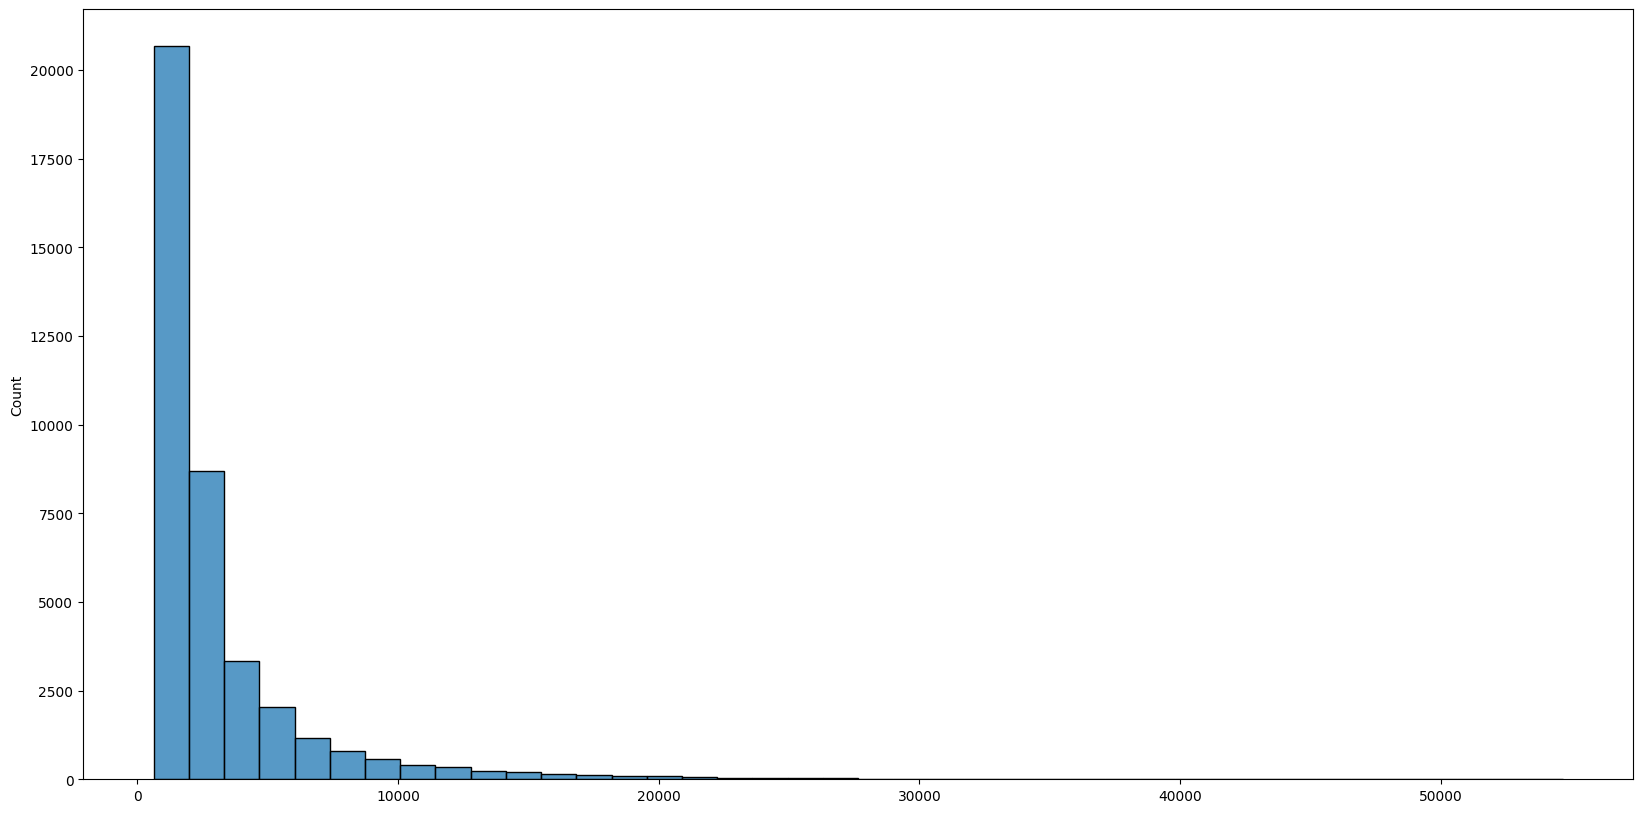

In [11]:
plt.figure(figsize=(20,10))
sns.histplot(area,bins=40)

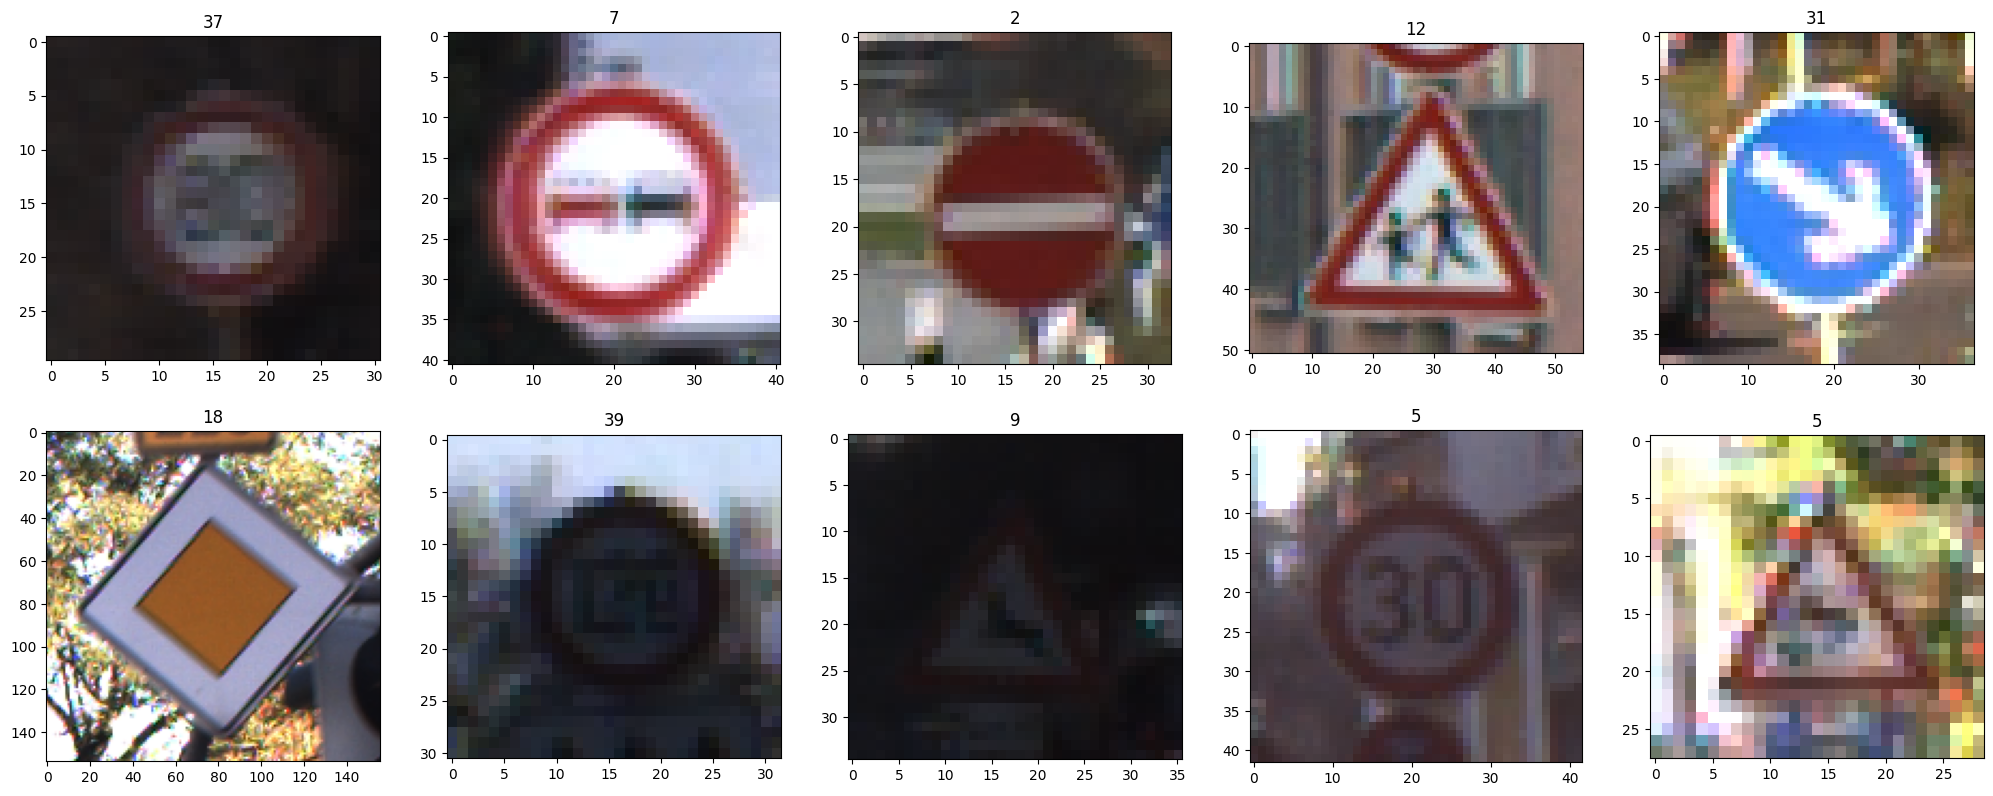

In [12]:
n_classes=43
plt.figure(figsize=(25,25))
for i in range(10):
    img_path=os.path.join(dataset_path,training_data.sample(10).iloc[i]["Path"])
    img=plt.imread(img_path)
    plt.subplot(5,5,i+1)
    plt.title(training_data.sample(10).iloc[i]["ClassId"])
    plt.imshow(img)


In [13]:
aspect_ratio=training_data["Width"]/training_data["Height"]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Image Aspect Ratios')

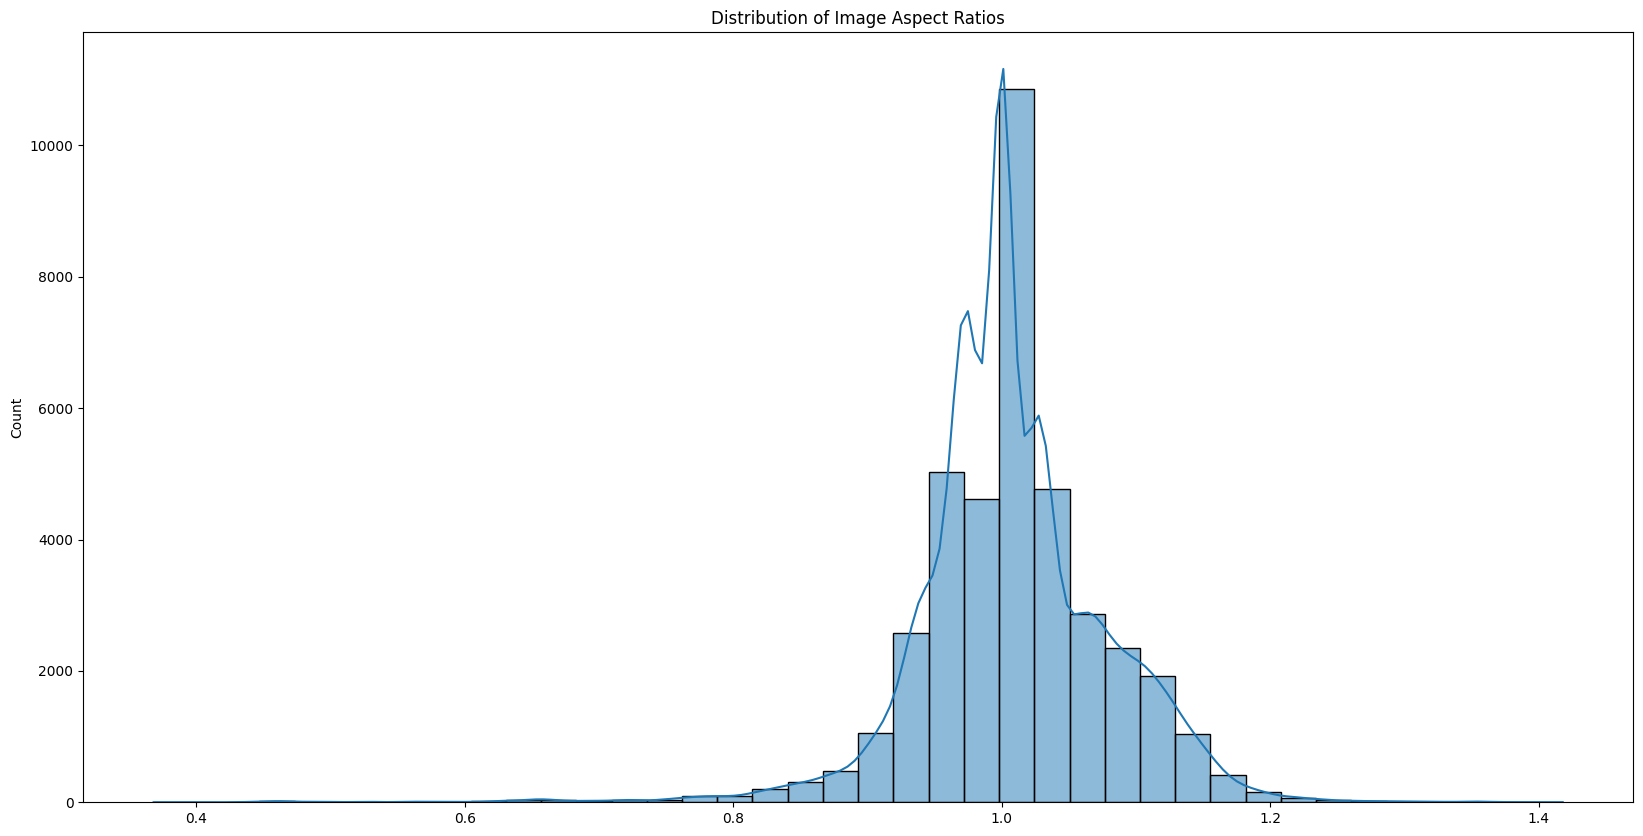

In [14]:
plt.figure(figsize=(20,10))
sns.histplot(aspect_ratio,bins=40,kde=True)
plt.title("Distribution of Image Aspect Ratios")

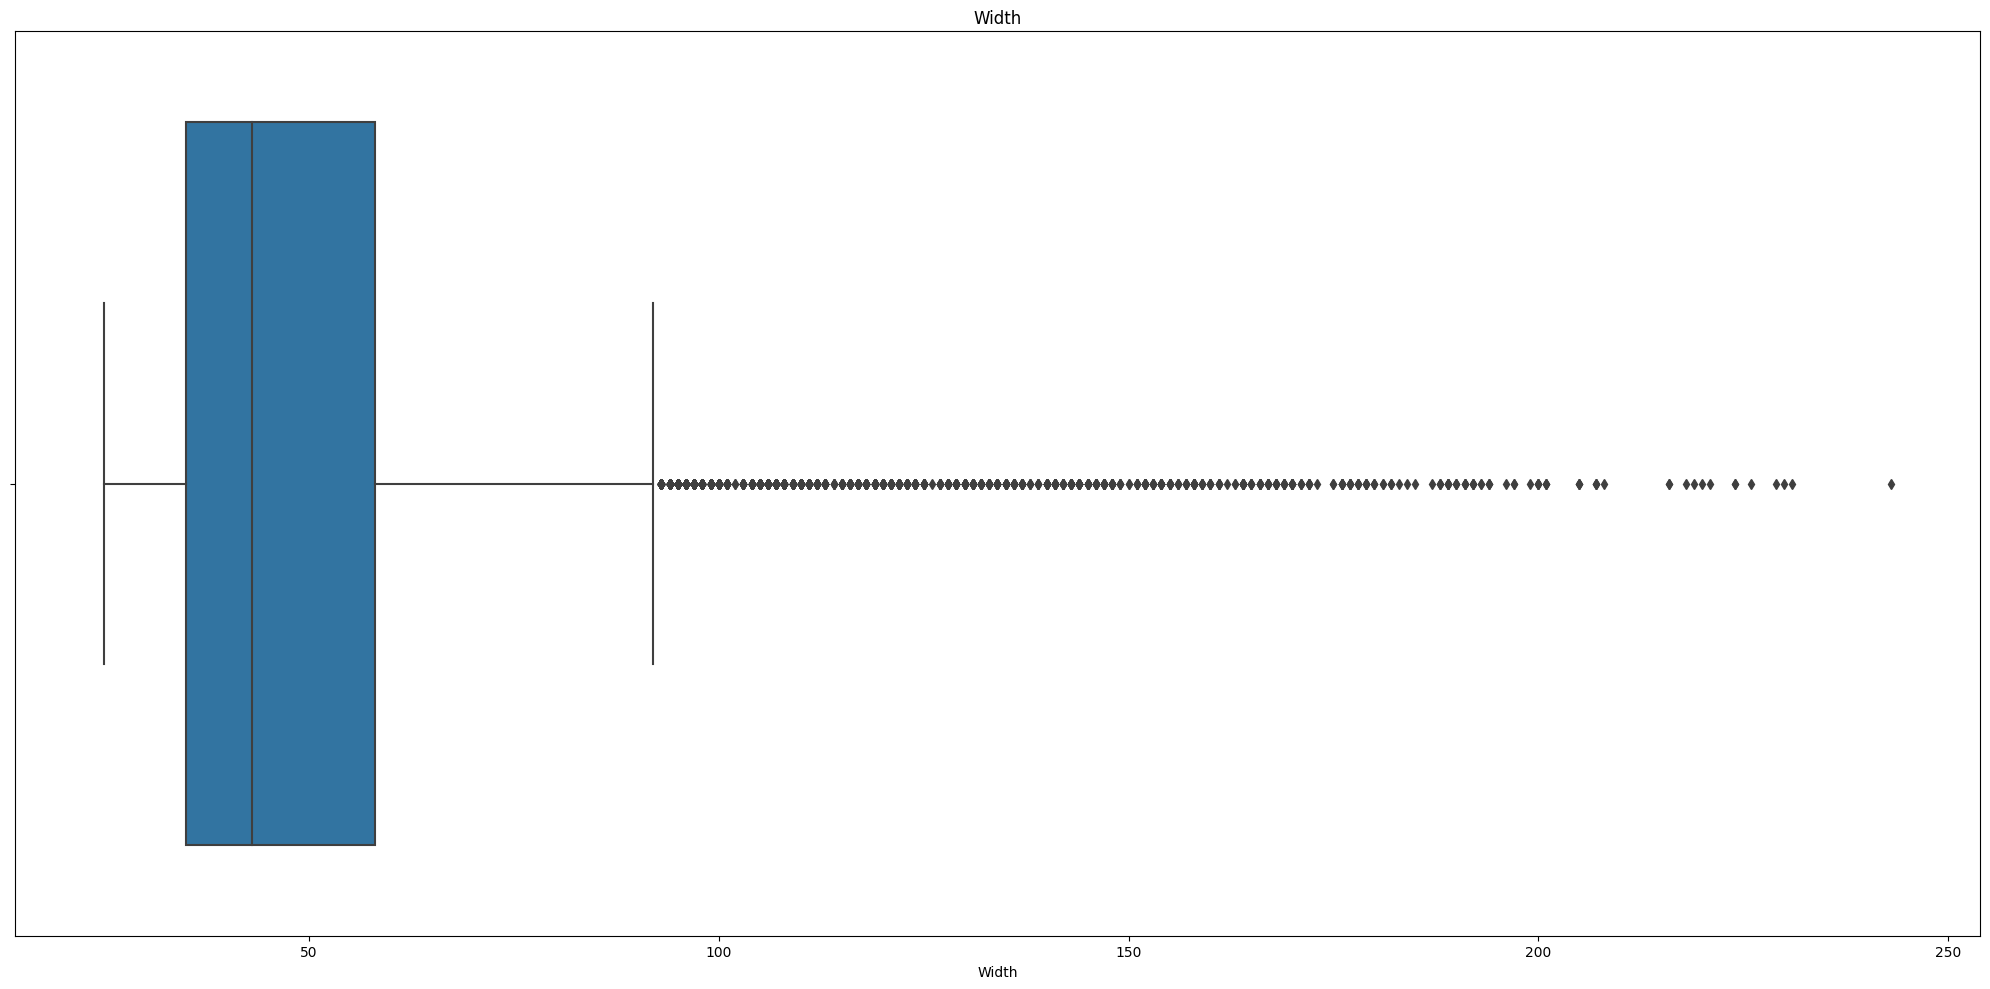

In [15]:
plt.figure(figsize=(20,10))
sns.boxplot(x=training_data['Width'])
plt.title("Width")
plt.tight_layout()

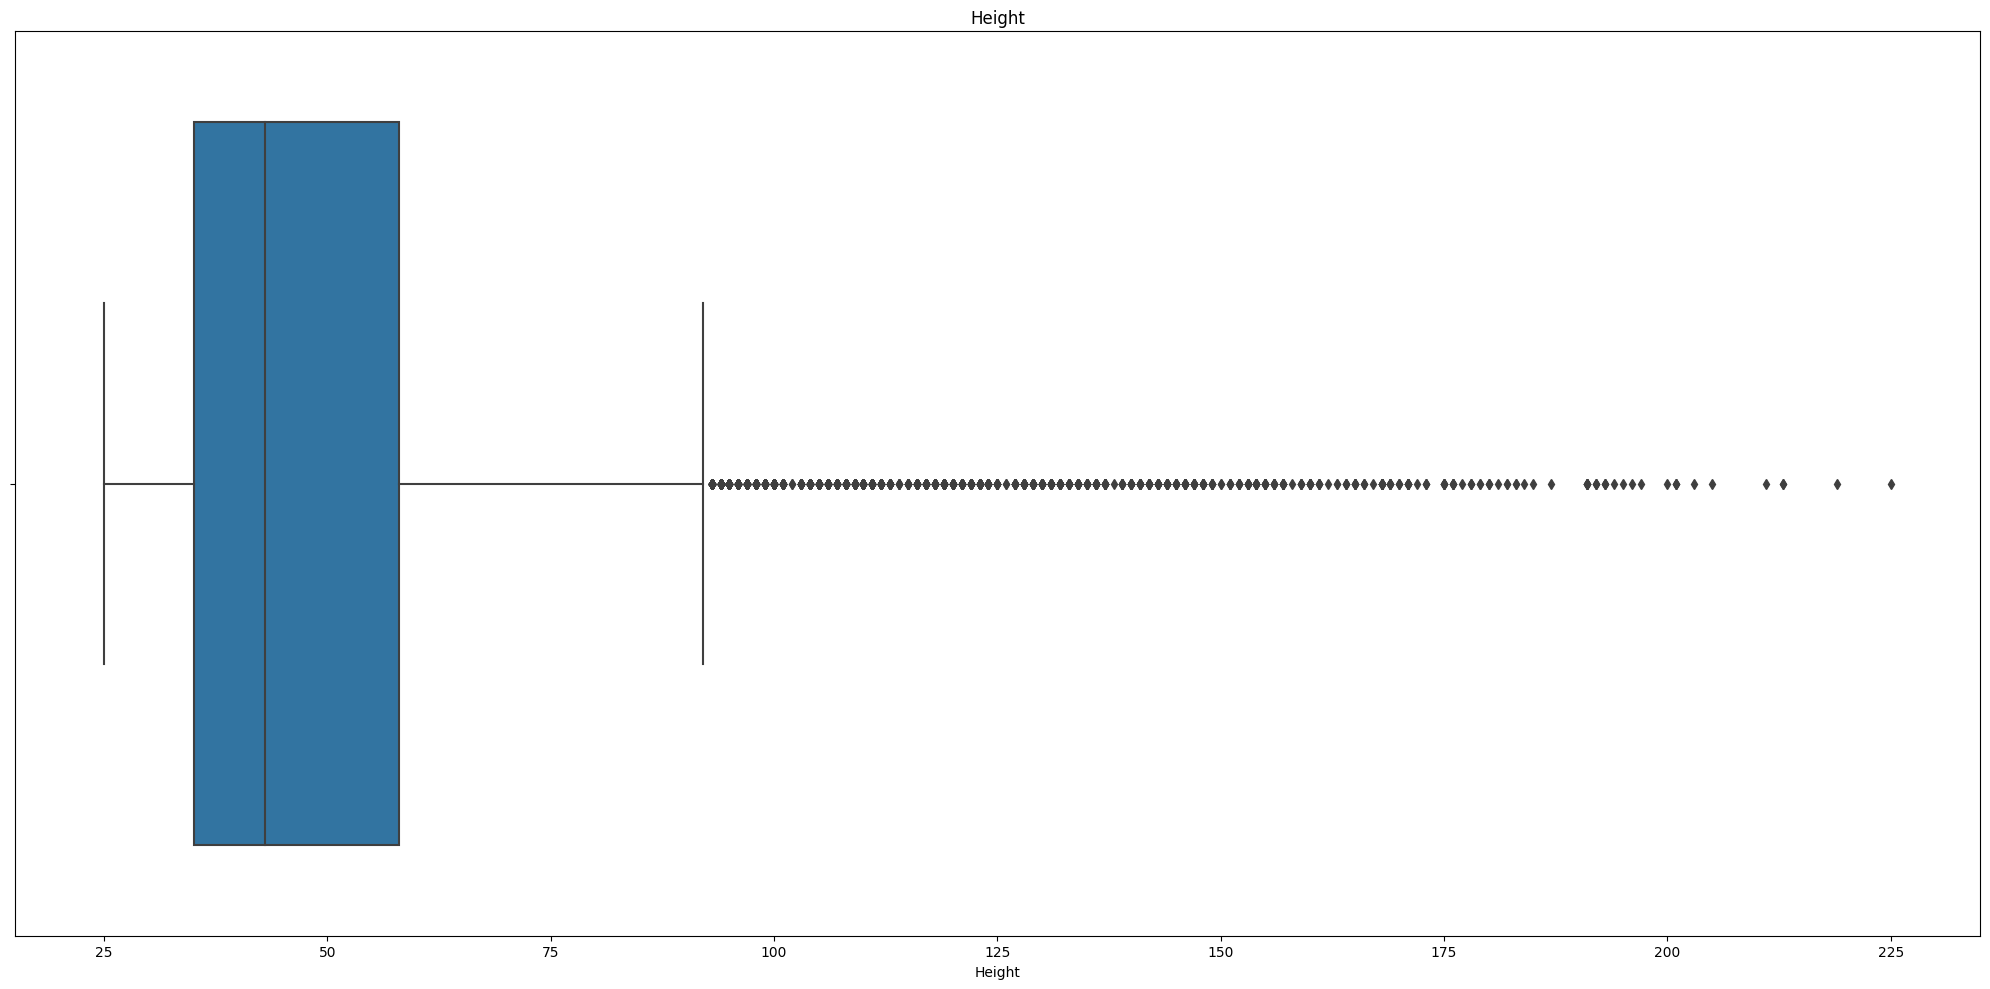

In [16]:
plt.figure(figsize=(20,10))
sns.boxplot(x=training_data['Height'])
plt.title("Height")
plt.tight_layout()

In [17]:
print("Min Width :",training_data["Width"].min())
print("Max Width :",training_data["Width"].max())
n_images = training_data.loc[training_data['Width'] > np.percentile(training_data['Width'], 75)]
print("Number of images with width > 75th percentile :", len(n_images))

Min Width : 25
Max Width : 243
Number of images with width > 75th percentile : 9592


In [18]:
print("Min Height :",training_data["Height"].min())
print("Max Height :",training_data["Height"].max())
n_images = training_data.loc[training_data['Height'] > np.percentile(training_data['Height'], 75)]
print("Number of images with width > 75th percentile :", len(n_images))

Min Height : 25
Max Height : 225
Number of images with width > 75th percentile : 9381


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


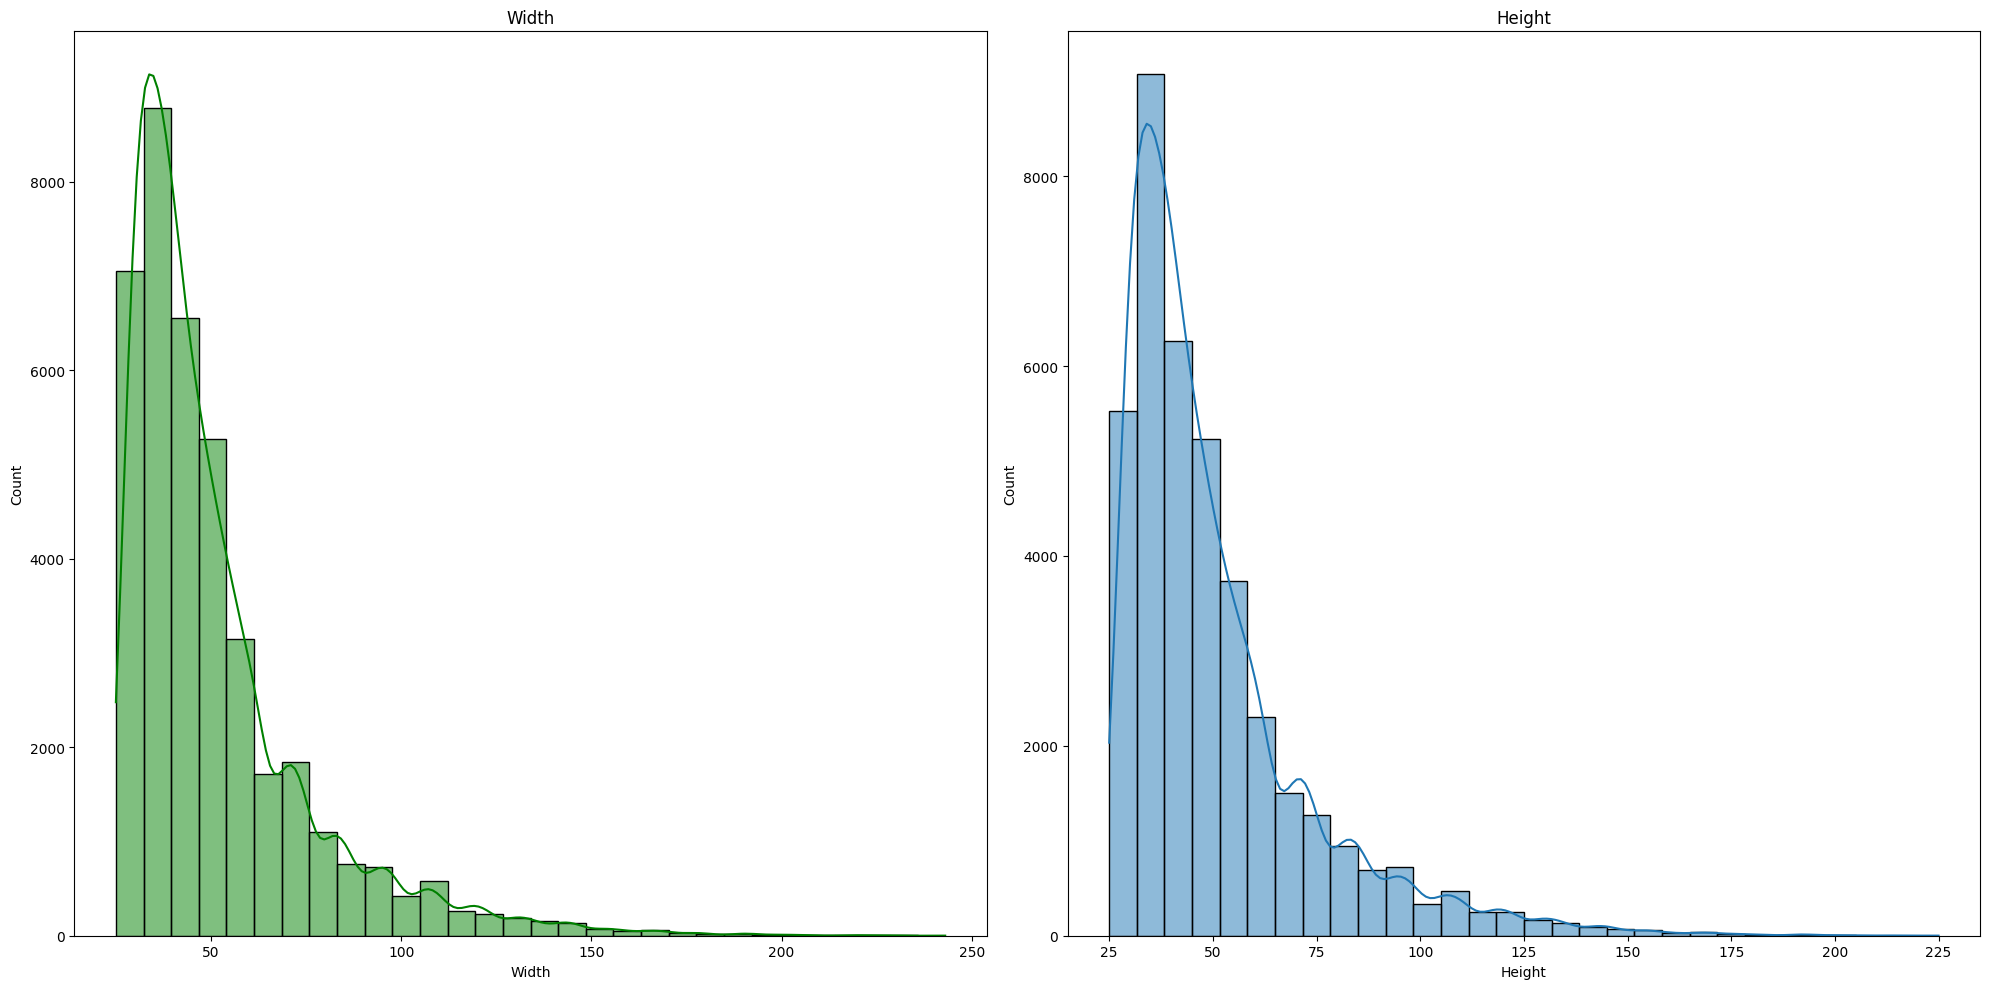

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.histplot(training_data['Width'], bins=30, kde=True,color='g')
plt.title("Width")
plt.subplot(1,2,2)
sns.histplot(training_data['Height'],bins=30,kde=True)
plt.title("Height")

plt.tight_layout()

# Data Preprocessing

In [20]:
import random
import torch
from torch.utils.data import Dataset,DataLoader
from albumentations.pytorch import ToTensorV2

In [21]:
def load_annotations(files_dataframe):
  annotations={}
  for i in range(files_dataframe.shape[0]):
      img_path=os.path.join(dataset_path,training_data.iloc[i]["Path"])
      box=training_data.iloc[i]["Roi.X1"],training_data.iloc[i]["Roi.Y1"],training_data.iloc[i]["Roi.X2"],training_data.iloc[i]["Roi.Y2"]
      label=int(training_data.iloc[i]["ClassId"])
      annotations[img_path]={'boxes':[box],'labels':[label]}

  return annotations

In [22]:
annotations=load_annotations(training_data)
print(f"Loaded annotations for {len(annotations)} images.")

Loaded annotations for 39209 images.


In [23]:
training_data['ClassId'].value_counts().max()

2250

In [24]:
dirs = []
for i in range(training_data.shape[0]):
    img_path = os.path.join(dataset_path, training_data.iloc[i]["Path"])
    # Using .iloc for safe indexing
    dirs.append((img_path, training_data.iloc[i]["ClassId"]))

print(f"Total Number of images : {len(dirs)}")

Total Number of images : 39209


In [25]:
def oversample_data(data):
    """
    Replicate minority class samples so that each class has the same number of images as the majority.
    """
    # Organize data by class
    data_by_class = {}
    for image_path, ann in annotations.items():
        label = ann['labels'][0]  # assuming one label per image
        data_by_class.setdefault(label, []).append((image_path, ann))

    max_count = max(len(items) for items in data_by_class.values())
    oversampled_data = []
    for label, items in data_by_class.items():
        current_count = len(items)
        if current_count < max_count:
            additional = random.choices(items, k=max_count - current_count)
            items.extend(additional)
        oversampled_data.extend(items)
    return oversampled_data

In [26]:
oversampled_data = oversample_data(annotations)
print(f"Total images after oversampling: {len(oversampled_data)}")

Total images after oversampling: 96750


In [27]:
train_transform = A.Compose([
    A.Resize(width=64, height=64),
    A.RandomCrop(width=56, height=56, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    # Enhancement for low-light conditions:
    A.CLAHE(clip_limit=2.0, p=0.5),
    # Enhancement for blurry images:
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [28]:
class GTSDatasetYOLO(Dataset):
    def __init__(self, data, transform=None):
        """
        data: list of tuples (image_path, annotation)
        transform: Albumentations transform supporting bounding boxes.
                   Expected bboxes are in Pascal VOC format: [x1, y1, x2, y2]
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, ann = self.data[idx]
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found: {image_path}")
        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Absolute bounding boxes and labels from annotations
        boxes = ann['boxes']  # List of boxes: [x1, y1, x2, y2]
        labels = ann['labels']  # List of labels

        # Apply Albumentations transform (which works in Pascal VOC format)
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, category_ids=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['category_ids']
        else:
            # Convert image to tensor if no transform is provided
            image = ToTensorV2()(image=image)['image']

        # Get image dimensions. If image is a tensor, its shape is (C, H, W)
        if isinstance(image, torch.Tensor):
            _, img_h, img_w = image.shape
        else:
            img_h, img_w, _ = image.shape

        # Convert each bounding box from Pascal VOC (absolute) to YOLO (normalized) format.
        yolo_boxes = []
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            x_center = ((x1 + x2) / 2) / img_w
            y_center = ((y1 + y2) / 2) / img_h
            width = (x2 - x1) / img_w
            height = (y2 - y1) / img_h
            yolo_boxes.append([label, x_center, y_center, width, height])

        yolo_boxes = torch.tensor(yolo_boxes, dtype=torch.float32)

        return image, yolo_boxes

In [29]:
dataset = GTSDatasetYOLO(oversampled_data, transform=train_transform)

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [32]:
test_annotations=load_annotations(test_data)

In [33]:
test_data.shape[0]

12630

In [34]:
oversampled_data[0]

('/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png',
 {'boxes': [(5, 5, 22, 20)], 'labels': [20]})

In [35]:
testing_data=[]
for i in range(test_data.shape[0]):
  img_path=os.path.join(dataset_path,test_data.iloc[i]["Path"])
  label=test_data.iloc[i]["ClassId"]
  box=[test_data.iloc[i]["Roi.X1"],test_data.iloc[i]["Roi.Y1"],test_data.iloc[i]["Roi.X2"],test_data.iloc[i]["Roi.Y2"]]
  testing_data.append((img_path,{'boxes':[box],'labels':[label]}))

# Model Development

In [36]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.3 MB/s eta 0:00:00a 0:00:01


In [37]:
from ultralytics import YOLO
import shutil
import glob
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [38]:
def convert_bbox_to_yolo(box, img_width, img_height):
    """
    Convert a single bounding box from Pascal VOC format (x1, y1, x2, y2)
    to YOLO format (x_center, y_center, width, height) with normalized coordinates.
    """
    x1, y1, x2, y2 = box
    x_center = ((x1 + x2) / 2) / img_width
    y_center = ((y1 + y2) / 2) / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return x_center, y_center, width, height

In [39]:
def create_yolo_dataset(data, output_images_dir, output_labels_dir):
    """
    Given a list of (image_path, annotation) tuples, copy images to output_images_dir
    and create corresponding YOLO annotation text files in output_labels_dir.

    Each annotation should be a dictionary containing:
      - 'boxes': list of bounding boxes in Pascal VOC format [x1, y1, x2, y2]
      - 'labels': list of labels corresponding to each bounding box.
    """
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)
    if not os.path.exists(output_labels_dir):
        os.makedirs(output_labels_dir)

    for image_path, ann in data:
        # Read the image to get its dimensions
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image {image_path}. Skipping.")
            continue
        img_height, img_width, _ = image.shape

        # Get the base filename (without extension)
        base_name = os.path.splitext(os.path.basename(image_path))[0]

        # Copy image to output_images_dir
        output_image_path = os.path.join(output_images_dir, os.path.basename(image_path))
        shutil.copy(image_path, output_image_path)

        # Create corresponding annotation text file
        label_file_path = os.path.join(output_labels_dir, base_name + ".txt")
        with open(label_file_path, "w") as f:
            boxes = ann['boxes']
            labels = ann['labels']
            for box, label in zip(boxes, labels):
                # Convert the box to YOLO format
                x_center, y_center, width, height = convert_bbox_to_yolo(box, img_width, img_height)
                # Write to file: class x_center y_center width height
                f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    print("Conversion complete!")


In [40]:
output_images_dir='images/train'
output_labels_dir='labels/train'

output_testimages_dir='images/val'
output_testlabels_dir='labels/val'


In [41]:
# os.makedirs(output_images_dir, exist_ok=True)
# os.makedirs(output_labels_dir, exist_ok=True)

# os.makedirs(output_testimages_dir, exist_ok=True)
# os.makedirs(output_testlabels_dir, exist_ok=True)

In [42]:
# create_yolo_dataset(oversampled_data, output_images_dir, output_labels_dir)
# create_yolo_dataset(testing_data, output_testimages_dir, output_testlabels_dir)

In [43]:
gtsrb_labels = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Give way",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Construction",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing zone",
    "End of no passing zone for vehicles over 3.5 metric tons"
]

In [44]:
def create_balanced_yolo_dataset(data, output_images_dir, output_labels_dir):
    """
    Given a list of (image_path, annotation) tuples, create a new dataset directory
    where each class has an equal number of samples. The images are copied into the output_images_dir,
    and YOLO-format annotation files are created in output_labels_dir.

    Each annotation is assumed to be a dictionary with:
        - 'boxes': list of bounding boxes in Pascal VOC format [x1, y1, x2, y2]
        - 'labels': list of labels corresponding to each bounding box (assumes one label per image)
    """
    # Create the output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Group the data by class label (assuming each image contains one object)
    data_by_class = {}
    for image_path, ann in data:
        label = ann['labels'][0]  # assume one label per image
        data_by_class.setdefault(label, []).append((image_path, ann))

    # Find the maximum sample count among all classes
    max_count = max(len(samples) for samples in data_by_class.values())
    print(f"Max sample count per class: {max_count}")

    # Oversample minority classes to match the maximum count
    balanced_data = []
    for label, items in data_by_class.items():
        current_count = len(items)
        if current_count < max_count:
            additional = random.choices(items, k=max_count - current_count)
            items.extend(additional)
        balanced_data.extend(items)

    print(f"Total balanced samples: {len(balanced_data)}")

    # To generate unique file names, maintain a counter for each class
    counters = {label: 0 for label in data_by_class.keys()}

    # Process each sample: copy image and create annotation file in YOLO format
    for image_path, ann in balanced_data:
        label = ann['labels'][0]
        counters[label] += 1
        # Generate a new filename: <label>_<counter>.<extension>
        ext = os.path.splitext(image_path)[1]
        new_filename = f"{label}_{counters[label]}{ext}"
        output_image_path = os.path.join(output_images_dir, new_filename)
        shutil.copy(image_path, output_image_path)

        # Read the image to get its dimensions
        image_cv = cv2.imread(image_path)
        if image_cv is None:
            print(f"Warning: Could not read image {image_path}. Skipping annotation.")
            continue
        img_height, img_width, _ = image_cv.shape

        # Create the corresponding YOLO annotation text file
        base_name = os.path.splitext(new_filename)[0]
        label_file_path = os.path.join(output_labels_dir, base_name + ".txt")
        with open(label_file_path, "w") as f:
            boxes = ann['boxes']
            # For each bounding box in the image (often one per image in GTSRB)
            for box in boxes:
                x_center, y_center, box_w, box_h = convert_bbox_to_yolo(box, img_width, img_height)
                # Write annotation line: class x_center y_center width height
                f.write(f"{label} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}\n")

    print("Balanced YOLO dataset creation complete!")



In [45]:
output_images_dir = "./balanced_dataset/images/train"
output_labels_dir = "./balanced_dataset/labels/train"

# Create the balanced YOLO-format dataset
create_balanced_yolo_dataset(oversampled_data, output_images_dir, output_labels_dir)
create_balanced_yolo_dataset(testing_data, "balanced_dataset/"+output_testimages_dir, "balanced_dataset/"+output_testlabels_dir)

Max sample count per class: 2250
Total balanced samples: 96750
Balanced YOLO dataset creation complete!
Max sample count per class: 750
Total balanced samples: 32250
Balanced YOLO dataset creation complete!


In [46]:
data_config={
    'path':'/kaggle/working/balanced_dataset',
    'train':'images/train',
    'val':'images/val',
    'nc':43,
    'names':gtsrb_labels
}

In [47]:
import json
import os

# Define the path to the Ultralytics settings file
settings_path = os.path.expanduser("~/.config/Ultralytics/settings.json")

# Check if the settings file exists
if not os.path.exists(settings_path):
    print(f"Settings file not found at {settings_path}.")
else:
    # Load current settings
    with open(settings_path, "r") as f:
        settings = json.load(f)

    # Display the current download directory
    old_download_dir = settings.get("download_dir", "")
    print(f"Old download_dir: {old_download_dir}")

    # Update the download directory to use the current working directory
    settings["download_dir"] = "."

    # Write the updated settings back to the file
    with open(settings_path, "w") as f:
        json.dump(settings, f, indent=4)

    print("settings.json updated successfully!")
    print(f"New download_dir: {settings['download_dir']}")


Old download_dir: 
settings.json updated successfully!
New download_dir: .


In [48]:
with open('data.yaml', 'w') as file:
    yaml.dump(data_config, file, default_flow_style=False)

print("data.yaml file created successfully!")

data.yaml file created successfully!


In [49]:
model=YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 68.9MB/s]


In [50]:
model.train(data='/kaggle/working/data.yaml', epochs=5)

Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/balanced_dataset/labels/train... 96750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96750/96750 [01:09<00:00, 1383.64it/s]


train: New cache created: /kaggle/working/balanced_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/balanced_dataset/labels/val... 32250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32250/32250 [00:23<00:00, 1351.72it/s]


val: New cache created: /kaggle/working/balanced_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.12G     0.6473      2.296      1.209         34        640: 100%|██████████| 6047/6047 [16:56<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [03:04<00:00,  5.48it/s]


                   all      32250      32250      0.859      0.905      0.926      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       3.1G     0.4896      0.966      1.073         43        640: 100%|██████████| 6047/6047 [16:37<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [03:00<00:00,  5.58it/s]


                   all      32250      32250      0.915      0.923      0.949      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       3.1G     0.4528     0.7529       1.05         41        640: 100%|██████████| 6047/6047 [16:23<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [03:00<00:00,  5.59it/s]


                   all      32250      32250      0.927      0.936      0.956      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       3.1G     0.4237     0.6369      1.033         35        640: 100%|██████████| 6047/6047 [16:16<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [02:59<00:00,  5.61it/s]


                   all      32250      32250       0.93      0.944      0.949      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       3.1G     0.3911     0.5594      1.018         34        640: 100%|██████████| 6047/6047 [16:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [03:00<00:00,  5.60it/s]


                   all      32250      32250      0.921      0.947      0.953      0.899

5 epochs completed in 1.628 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1008/1008 [02:57<00:00,  5.69it/s]


                   all      32250      32250       0.92      0.947      0.953      0.899
  Speed limit (20km/h)        750        750      0.999          1      0.995      0.956
  Speed limit (30km/h)        750        750      0.978      0.995      0.995      0.942
  Speed limit (50km/h)        750        750      0.961      0.995      0.995      0.949
  Speed limit (60km/h)        750        750      0.976      0.987      0.994       0.94
  Speed limit (70km/h)        750        750      0.979      0.996      0.995      0.928
  Speed limit (80km/h)        750        750      0.916      0.992      0.991      0.929
End of speed limit (80km/h)        750        750          1      0.987      0.995      0.914
 Speed limit (100km/h)        750        750      0.966          1      0.995      0.926
 Speed limit (120km/h)        750        750      0.993      0.936      0.994      0.928
            No passing        750        750      0.995      0.997      0.995      0.947
No passing for v

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1a2f262020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03

In [52]:
torch.save(model.state_dict(), "detection_model_state.pth")

In [53]:
import torch

In [54]:
metrics=model.val(data='/kaggle/working/data.yaml',imgsz=640,conf=0.6,iou=0.6)

Ultralytics 8.3.97 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/balanced_dataset/labels/val.cache... 32250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32250/32250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2016/2016 [03:28<00:00,  9.68it/s]


                   all      32250      32250      0.945      0.914      0.929      0.887
  Speed limit (20km/h)        750        750          1      0.984      0.991      0.959
  Speed limit (30km/h)        750        750      0.997      0.979      0.989      0.949
  Speed limit (50km/h)        750        750      0.987      0.993      0.995      0.959
  Speed limit (60km/h)        750        750      0.992      0.963      0.981      0.937
  Speed limit (70km/h)        750        750      0.996      0.987      0.992      0.937
  Speed limit (80km/h)        750        750      0.973      0.968      0.981      0.934
End of speed limit (80km/h)        750        750          1      0.975      0.987      0.923
 Speed limit (100km/h)        750        750      0.986      0.999      0.995       0.94
 Speed limit (120km/h)        750        750          1      0.912      0.956      0.908
            No passing        750        750          1      0.996      0.995      0.957
No passing for v

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [55]:
print(f"mAP@50: {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")
print(f"Mean Precision: {np.mean(metrics.box.p):.4f}")
print(f"Mean Recall: {np.mean(metrics.box.r):.4f}")

mAP@50: 0.9294
mAP@50-95: 0.8874
Mean Precision: 0.9445
Mean Recall: 0.9144


In [56]:
# Classwise Precision and Recall
for i, (p, r) in enumerate(zip(metrics.box.p, metrics.box.r)):
    print(f"Class {i}: Precision = {p:.4f}, Recall = {r:.4f}")

Class 0: Precision = 1.0000, Recall = 0.9840
Class 1: Precision = 0.9973, Recall = 0.9787
Class 2: Precision = 0.9868, Recall = 0.9933
Class 3: Precision = 0.9918, Recall = 0.9627
Class 4: Precision = 0.9960, Recall = 0.9867
Class 5: Precision = 0.9732, Recall = 0.9680
Class 6: Precision = 1.0000, Recall = 0.9747
Class 7: Precision = 0.9855, Recall = 0.9987
Class 8: Precision = 1.0000, Recall = 0.9120
Class 9: Precision = 1.0000, Recall = 0.9960
Class 10: Precision = 1.0000, Recall = 0.9987
Class 11: Precision = 1.0000, Recall = 0.9933
Class 12: Precision = 1.0000, Recall = 0.9760
Class 13: Precision = 1.0000, Recall = 0.9973
Class 14: Precision = 1.0000, Recall = 0.9867
Class 15: Precision = 1.0000, Recall = 0.9907
Class 16: Precision = 1.0000, Recall = 1.0000
Class 17: Precision = 1.0000, Recall = 1.0000
Class 18: Precision = 1.0000, Recall = 0.9800
Class 19: Precision = 0.7711, Recall = 0.9253
Class 20: Precision = 0.8131, Recall = 0.6613
Class 21: Precision = 1.0000, Recall = 0.902

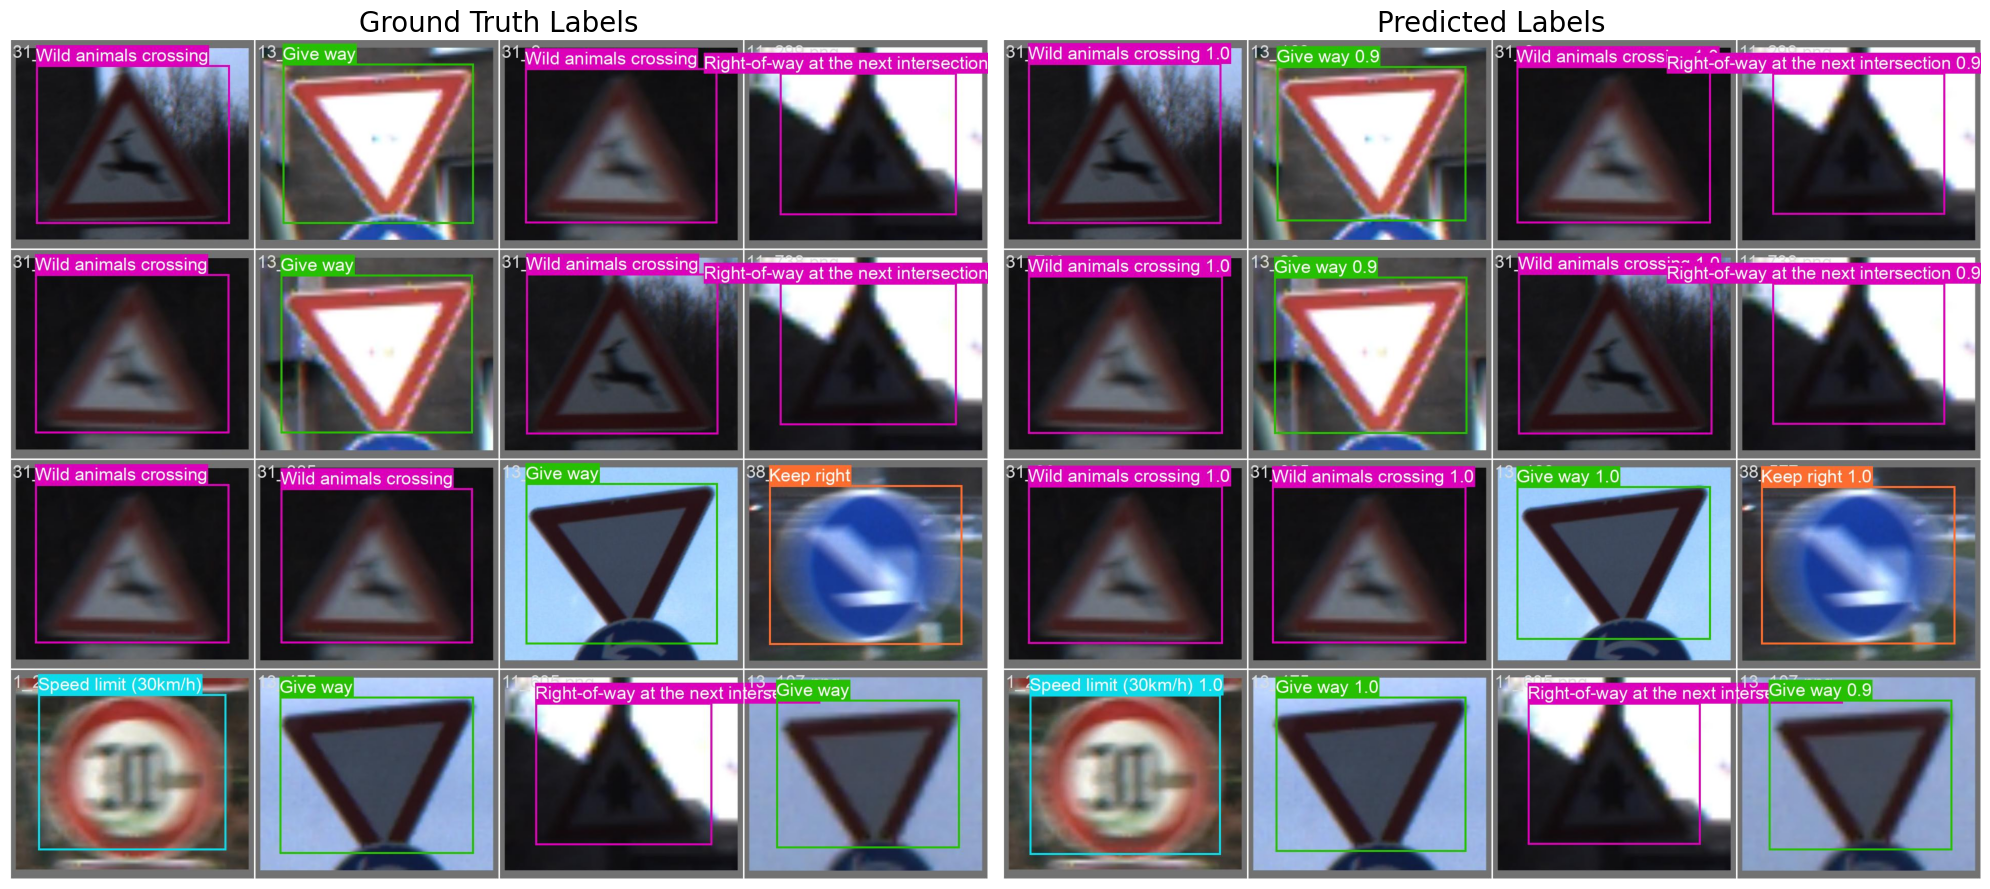

In [69]:
# Define the image paths
img_path = "/kaggle/working/runs/detect/train2/val_batch2_labels.jpg"
img_path2 = "/kaggle/working/runs/detect/train2/val_batch2_pred.jpg"

# Read the images
true_image = cv2.imread(img_path)
pred_image = cv2.imread(img_path2)

# Convert images from BGR to RGB for proper color display in matplotlib
true_image_rgb = cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB)
pred_image_rgb = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)

# Create a large figure
plt.figure(figsize=(20, 10))

# Plot the ground truth image
plt.subplot(1, 2, 1)
plt.imshow(true_image_rgb)
plt.title("Ground Truth Labels", fontsize=20)
plt.axis("off")

# Plot the prediction image
plt.subplot(1, 2, 2)
plt.imshow(pred_image_rgb)
plt.title("Predicted Labels", fontsize=20)
plt.axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

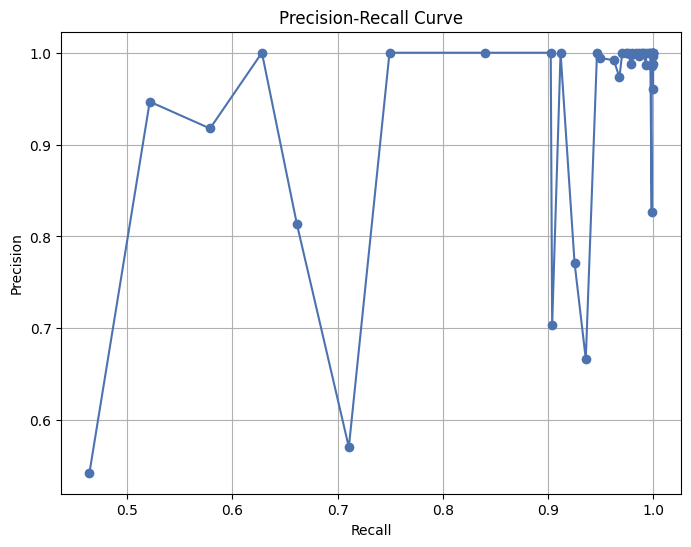

In [79]:
precision = np.array(metrics.box.p)  # Shape: (num_classes,)
recall = np.array(metrics.box.r)  # Shape: (num_classes,)

# Sort values for proper curve plotting
sorted_indices = np.argsort(recall)
sorted_recall = recall[sorted_indices]
sorted_precision = precision[sorted_indices]

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(sorted_recall, sorted_precision, marker="o", linestyle="-", color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


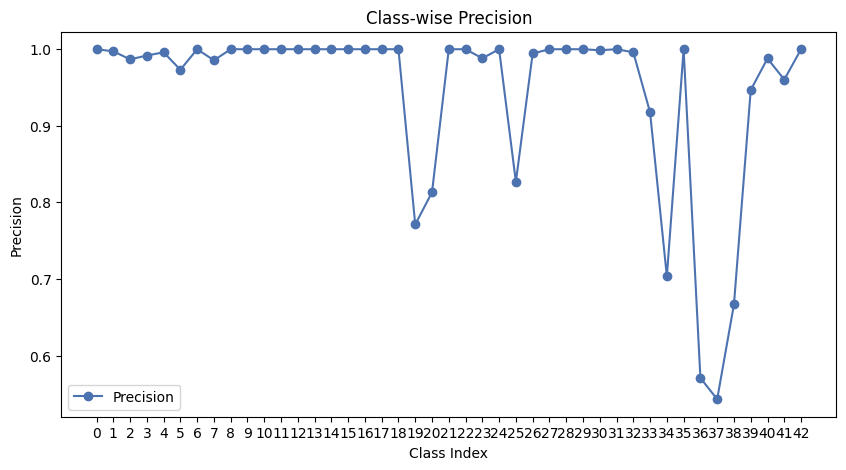

In [76]:
precision = np.array(metrics.box.p)  # Precision per class

plt.figure(figsize=(10, 5))
plt.plot(range(len(precision)), precision, marker='o', linestyle='-', color='b', label="Precision")

plt.xlabel("Class Index")
plt.ylabel("Precision")
plt.title("Class-wise Precision")
plt.xticks(range(len(precision)))  # Label x-axis with class indices
plt.legend()
plt.show()


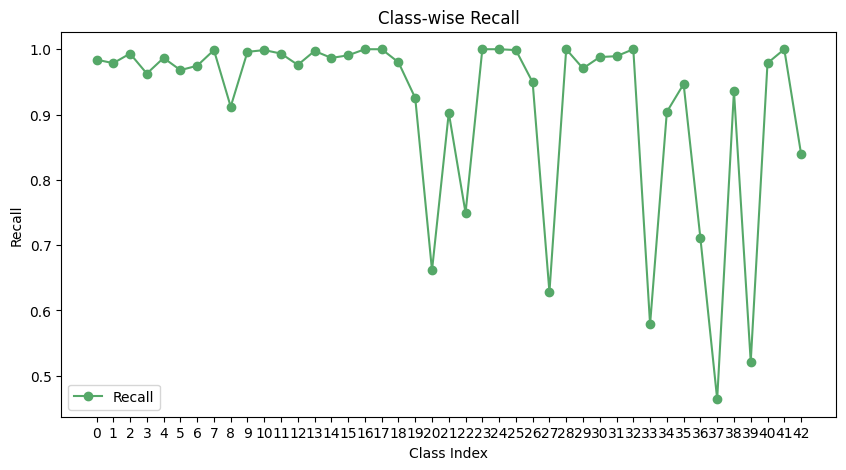

In [78]:
recall = np.array(metrics.box.r)  # Recall per class

plt.figure(figsize=(10, 5))
plt.plot(range(len(recall)), recall, marker='o', linestyle='-', color='g', label="Recall")

plt.xlabel("Class Index")
plt.ylabel("Recall")
plt.title("Class-wise Recall")
plt.xticks(range(len(recall)))  # Label x-axis with class indices
plt.legend()
plt.show()

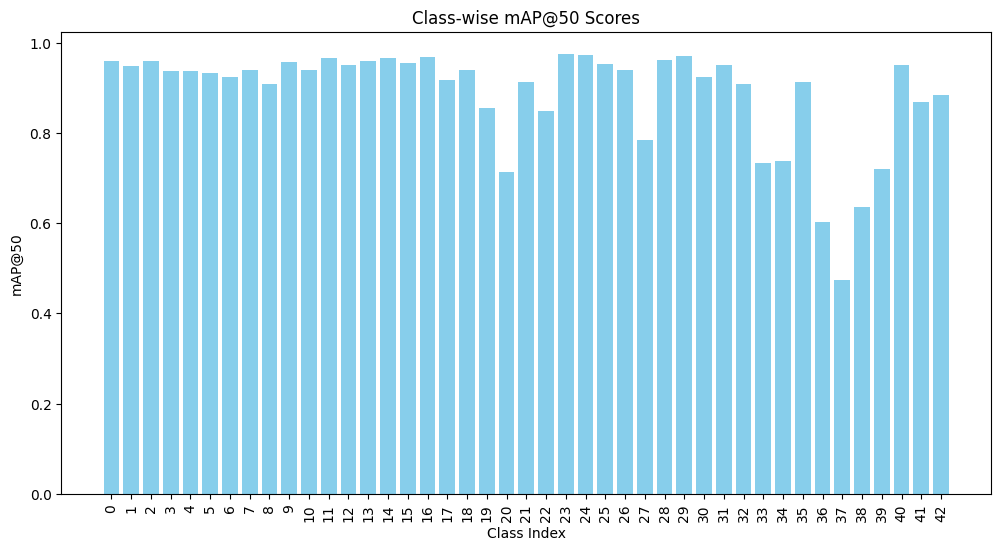

In [83]:
class_map50 = metrics.box.maps  # No need for parentheses

plt.figure(figsize=(12, 6))
plt.bar(range(len(class_map50)), class_map50, color="skyblue")

# Label x-axis with class indices
plt.xticks(range(len(class_map50)), range(len(class_map50)), rotation=90)

plt.xlabel("Class Index")
plt.ylabel("mAP@50")
plt.title("Class-wise mAP@50 Scores")
plt.show()


0: 576x640 1 Slippery road, 10.6ms
Speed: 3.2ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


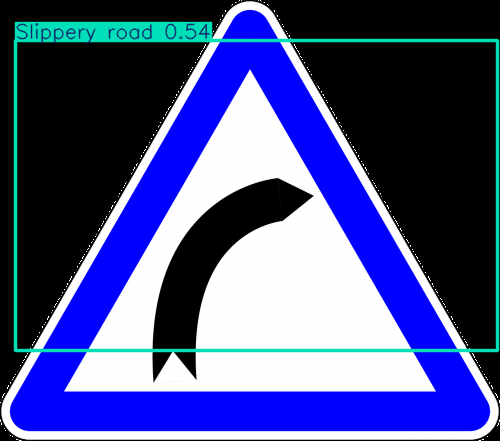

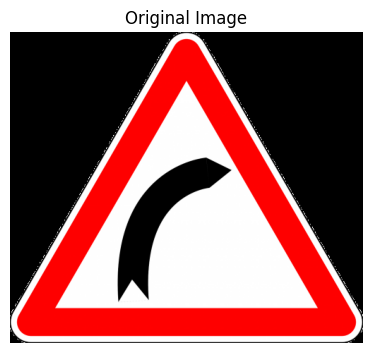


0: 448x640 1 Speed limit (30km/h), 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


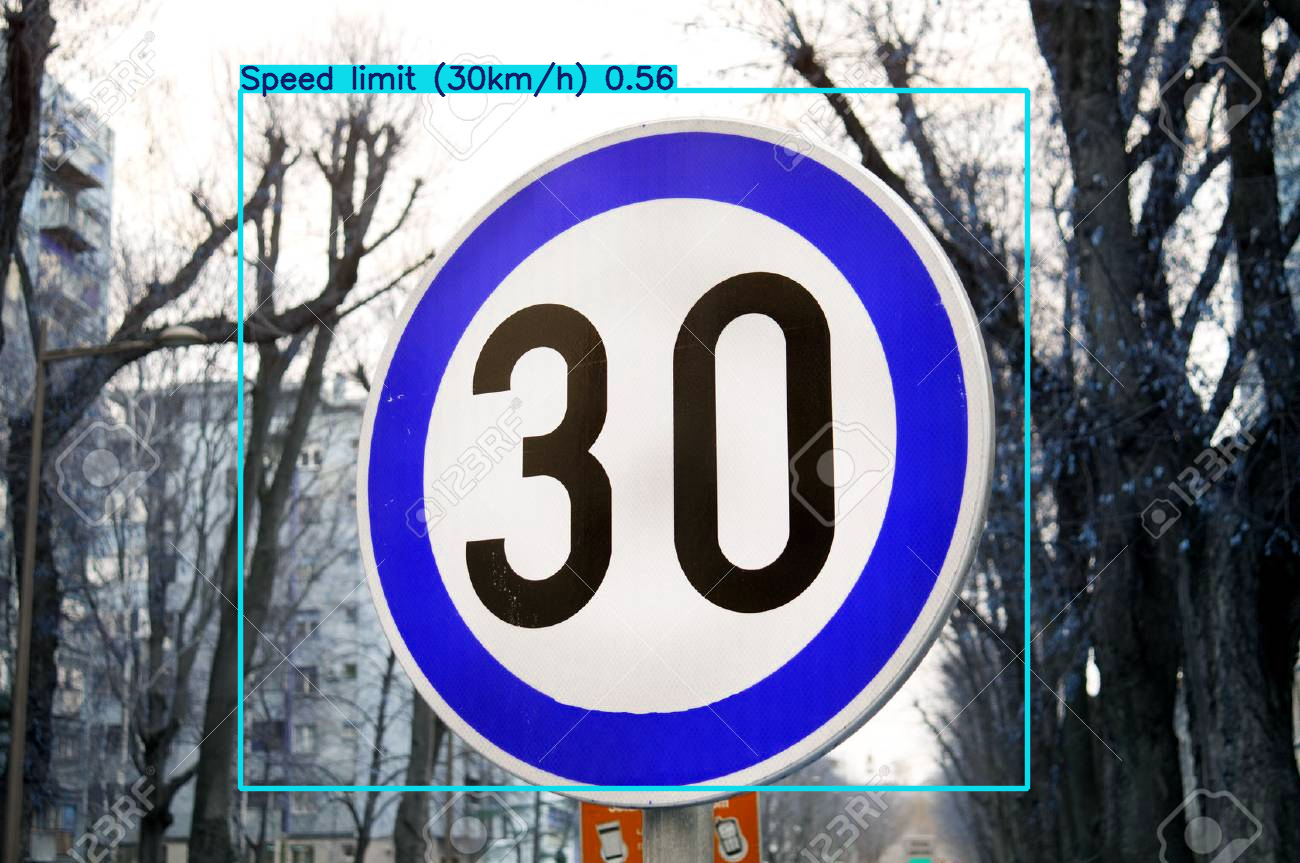

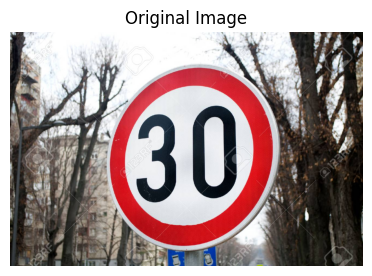

In [102]:
new_path="/kaggle/input/images"

for files in os.listdir(new_path):
    img_path = os.path.join(new_path, files)
    
    # Read image (BGR format) and convert to RGB
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run YOLOv8 inference
    results = model(img_rgb)

    # Plot original image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Original Image")
    results[0].show()  # Show the detection results

    plt.show()